<a href="https://colab.research.google.com/github/keirkwame/axionEmu/blob/main/Open_access_of_2e5_emulator_NN_tt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# setting the seed for reproducibility
np.random.seed(2)
tf.random.set_seed(4)

#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
model_parameters = ['h', 
                    'tau_reio', 
                    'omega_b', 
                    'n_s', 
                    'ln10A_s', 
                    'omega_cdm',
                    'log10ma',
                    'omega_ax' 
                    ]

In [3]:
np.linspace(0,28,15)

array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.,
       26., 28.])

In [4]:
import pickle
collection_list = []
for i in np.linspace(0,28,15):
    f = open('/home/anran/axionCAMB/test_data_collect_9params_5e5_mp_test_'+str(int(i))+'.pkl', 'rb')
    collection = pickle.load(f)
    f.close()
    print(len(collection['C_tt']))
    collection_list.append(collection)
    
import random
random.shuffle(collection_list)

2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000


In [5]:
import pickle
for i in np.linspace(0,28,15):
    f = open('/home/anran/axionCAMB/test_data_collect_9params_5e5_mp_test_'+str(int(i)+30)+'.pkl', 'rb')
    collection = pickle.load(f)
    f.close()
    print(len(collection['C_tt']))
    collection_list.append(collection)
    
import random
random.shuffle(collection_list)

2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000
2000


In [6]:
import numpy as np
parameters_list = {}
for key in collection['params']:
    parameters_list[key] = np.array([])

C_tt_list = []

for i in range(30):
    para = collection_list[i]['params']
    C_tt_list.extend(collection_list[i]['C_tt'])
    for key in para:
      parameters_list[key] = np.concatenate((parameters_list[key], para[key]))
cut_off = 54000
import copy
training_parameters_ = copy.deepcopy(parameters_list)
h_0 = training_parameters_['H_0'][:cut_off]/100
ln10_10A_s = np.log(training_parameters_['A_s'][:cut_off]*10**10)
ma_mass = np.array(training_parameters_['ma'][:cut_off]*10**32,dtype='float64')
ma_mass = np.log10(ma_mass)
training_parameters = dict()
training_parameters['omega_b'] = training_parameters_['omega_b'][:cut_off]
training_parameters['omega_cdm'] = training_parameters_['omega_cdm'][:cut_off]
training_parameters['h'] = h_0
training_parameters['tau_reio'] = training_parameters_['tau_reio'][:cut_off]
training_parameters['n_s'] = training_parameters_['n_s'][:cut_off]
training_parameters['ln10A_s'] = ln10_10A_s
training_parameters['log10ma'] = ma_mass
training_parameters['omega_ax'] = training_parameters_['omega_ax'][:cut_off]
ell_range = np.linspace(2,2508, 2507)

test_parameters_ = copy.deepcopy(parameters_list)
h_0 = test_parameters_['H_0'][cut_off:]/100
ln10_10A_s = np.log(test_parameters_['A_s'][cut_off:]*10**10)
ma_mass = np.array(test_parameters_['ma'][cut_off:]*10**32, dtype = 'float64')
ma_mass = np.log10(ma_mass)
test_parameters = dict()
test_parameters['omega_b'] = test_parameters_['omega_b'][cut_off:]
test_parameters['omega_cdm'] = test_parameters_['omega_cdm'][cut_off:]
test_parameters['h'] = h_0
test_parameters['tau_reio'] = test_parameters_['tau_reio'][cut_off:]
test_parameters['n_s'] = test_parameters_['n_s'][cut_off:]
test_parameters['ln10A_s'] = ln10_10A_s
test_parameters['omega_ax'] = test_parameters_['omega_ax'][cut_off:]
test_parameters['log10ma'] = ma_mass

spectra_= np.array(C_tt_list)/(7.4311*10**(12))
print(spectra_.shape)
spectra_ = spectra_[:,:2507]/(ell_range*(ell_range+1)/(2.*np.pi))
training_log_spectra = np.log10(spectra_)[:cut_off,:]
testing_spectra = spectra_[cut_off:,:]
print('number of training spectra: ', training_log_spectra.shape)
print('number of testing spectra: ', testing_spectra.shape)



(60000, 5999)
number of training spectra:  (54000, 2507)
number of testing spectra:  (6000, 2507)


In [7]:
test_collection = {}
test_collection['training_parameters'] = training_parameters
test_collection['test_parameters'] = test_parameters
test_collection['training_log_spectra'] = training_log_spectra
test_collection['testing_spectra'] = testing_spectra
import pickle
f = open('test_collection.pkl', 'wb')
pickle.dump(test_collection, f)
f.close()

In [ ]:
##Only for Google Colab
!git clone https://github.com/keirkwame/axionEmu.git

In [8]:
from axionEmu.cosmopower import cosmopower_NN

# instantiate NN class
cp_nn = cosmopower_NN(parameters=model_parameters, 
                      modes=ell_range, 
                      n_hidden = [512, 512, 512,512], # 4 hidden layers, each with 512 nodes
                      verbose=True, # useful to understand the different steps in initialisation and training
                      )


Initialized cosmopower_NN model, 
mapping 8 input parameters to 2507 output modes, 
using 4 hidden layers, 
with [512, 512, 512, 512] nodes, respectively. 



In [ ]:
import tensorflow as tf
with tf.device('/device:GPU:0'): # ensures we are running on a GPU
    # train
    cp_nn.train(training_parameters=training_parameters,
                training_features=training_log_spectra,
                filename_saved_model='TT_cp_NN_2e5_test_30_t0',
                # cooling schedule
                validation_split=0.1,
                learning_rates=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
                batch_sizes=[1024,1024,1024,1024,1024],
                gradient_accumulation_steps = [1, 1, 1, 1, 1],
                # early stopping set up
                patience_values = [100,100,100,100,100],
                max_epochs = [1000,1000,1000,1000,1000],
                )


In [9]:
cp_nn = cosmopower_NN(restore=True, 
                      restore_filename='TT_cp_NN_2e5_test_30_t0',
                      )


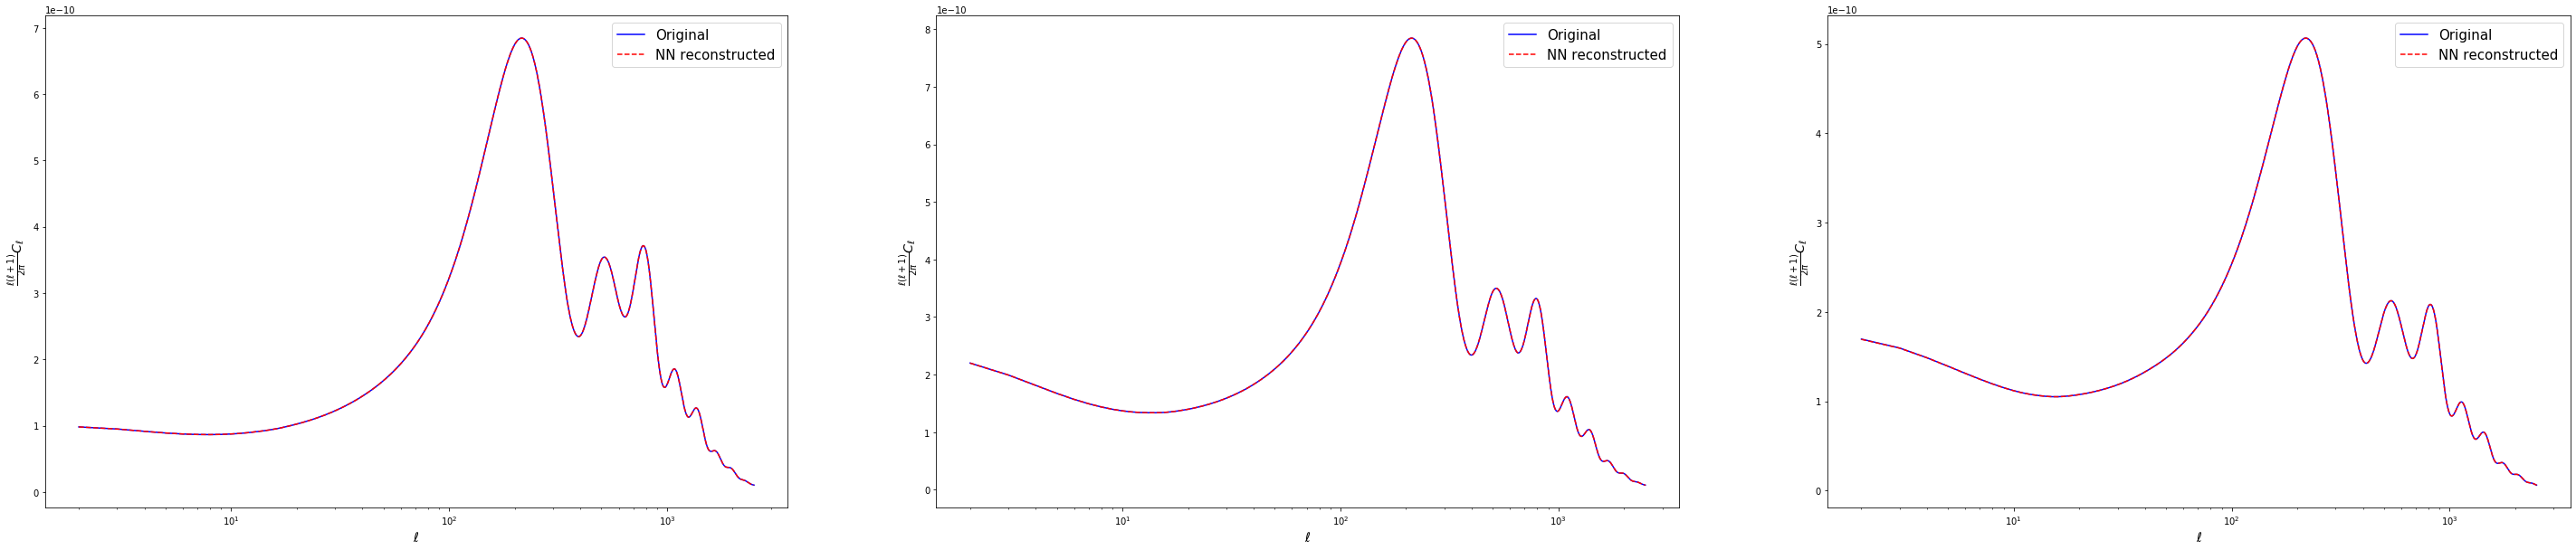

In [10]:
predicted_testing_spectra = cp_nn.ten_to_predictions_np(test_parameters)
import matplotlib.pyplot as plt
from matplotlib import gridspec
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(50,10))
for i in range(3):
    pred = predicted_testing_spectra[i]*ell_range*(ell_range+1)/(2.*np.pi)
    true = testing_spectra[i]*ell_range*(ell_range+1)/(2.*np.pi)
    ax[i].semilogx(ell_range, true, 'blue', label = 'Original')
    ax[i].semilogx(ell_range, pred, 'red', label = 'NN reconstructed', linestyle='--')
    ax[i].set_xlabel('$\ell$', fontsize='x-large')
    ax[i].set_ylabel('$\\frac{\ell(\ell+1)}{2 \pi} C_\ell$', fontsize='x-large')
    ax[i].legend(fontsize=15)
plt.savefig('examples_reconstruction_TT_2e5_30_0.pdf')

In [ ]:
##Only for Google Colab
!git clone https://github.com/simonsobs/so_noise_models

[  40.   41.   42. ... 2506. 2507. 2508.]
(2469,) (6000, 2507) (2469,)
diff_.shape is  (6000,)


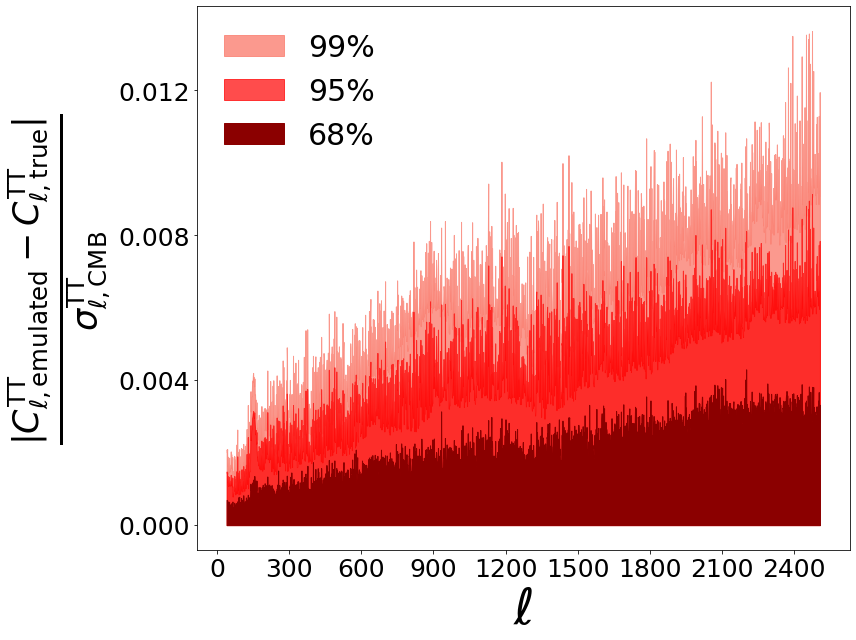

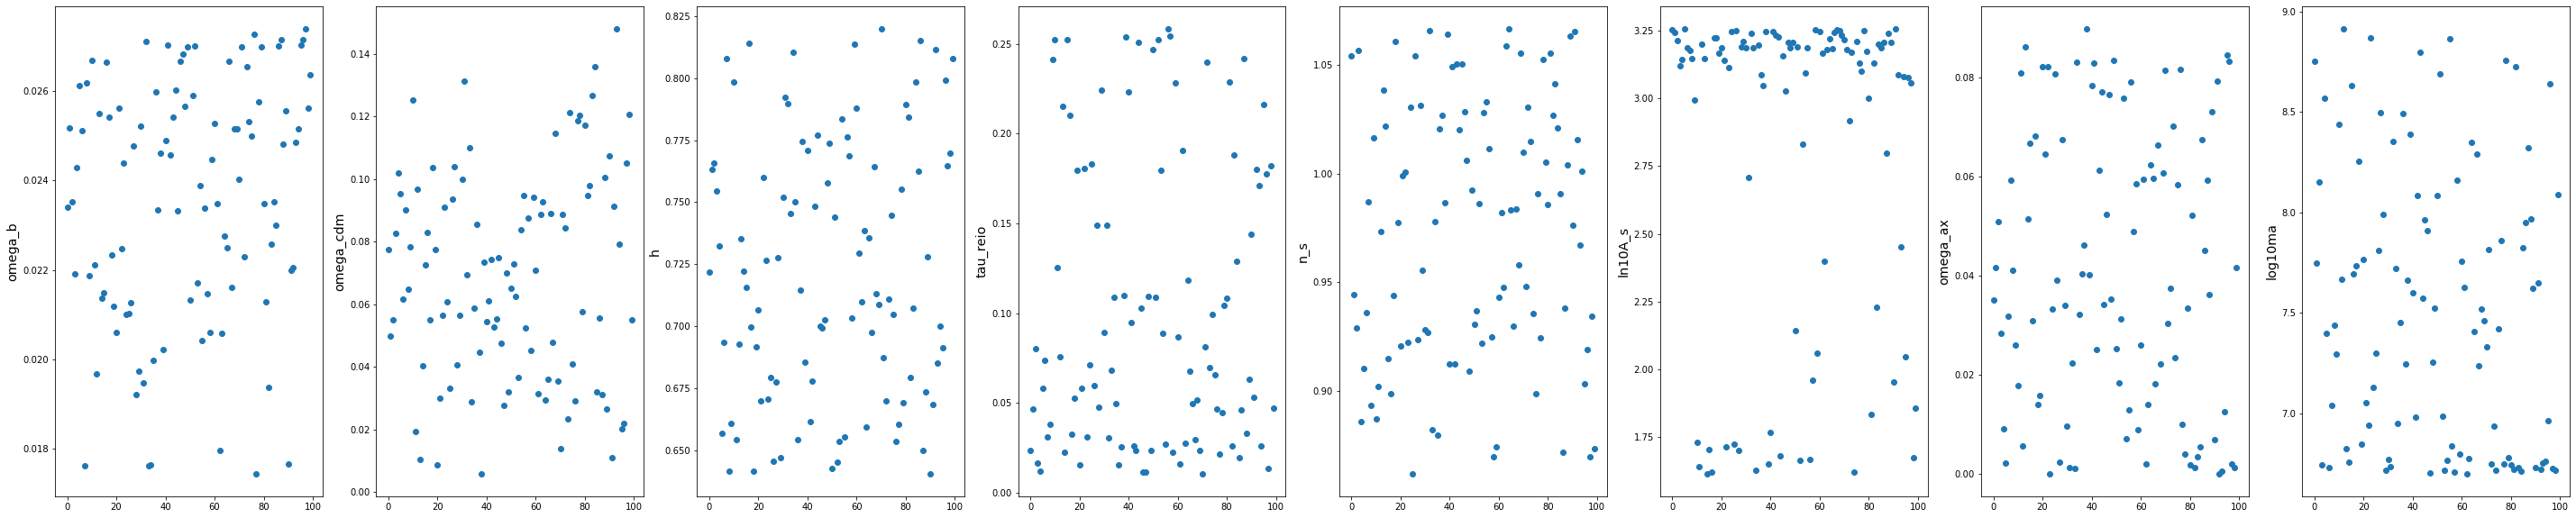

In [11]:
# load noise models from the SO noise repo
noise_levels_load = np.loadtxt('./so_noise_models/LAT_comp_sep_noise/v3.1.0/SO_LAT_Nell_T_atmv1_goal_fsky0p4_ILC_CMB.txt')
conv_factor = (2.7255e6)**2

ells = noise_levels_load[:, 0]
SO_TT_noise = noise_levels_load[:, 1][:2509-40] / conv_factor ##6001-40
new_ells = ells[:2509-40] ##6001-40

f_sky = 0.4
prefac = np.sqrt(2/(f_sky*(2*new_ells+1)))

##Cut off some spectra
print(new_ells)
print(prefac.shape, testing_spectra.shape, SO_TT_noise.shape)
#testing_spectra = testing_spectra[:6001-40]

denominator = prefac*(testing_spectra[:, 38:]+SO_TT_noise)  # use all of them
diff = np.abs((predicted_testing_spectra[:, 38:] - testing_spectra[:, 38:])/(denominator))

# Compute percentiles
percentiles = np.zeros((4, diff.shape[1]))

percentiles[0] = np.percentile(diff, 68, axis = 0)
percentiles[1] = np.percentile(diff, 95, axis = 0)
percentiles[2] = np.percentile(diff, 99, axis = 0)
percentiles[3] = np.percentile(diff, 99.9, axis = 0)

plt.figure(figsize=(12, 9))
plt.fill_between(new_ells, 0, percentiles[2,:], color = 'salmon', label = '99%', alpha=0.8)
plt.fill_between(new_ells, 0, percentiles[1,:], color = 'red', label = '95%', alpha = 0.7)
plt.fill_between(new_ells, 0, percentiles[0,:], color = 'darkred', label = '68%', alpha = 1)

# plt.ylim(0, 0.2)

plt.legend(frameon=False, fontsize=30, loc='upper left')
plt.ylabel(r'$\frac{| C_{\ell, \rm{emulated}}^{\rm{TT}} - C_{\ell, \rm{true}}^{\rm{TT}}|} {\sigma_{\ell, \rm{CMB}}^{\rm{TT}}}$', fontsize=50)
plt.xlabel(r'$\ell$',  fontsize=50)

ax = plt.gca()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.setp(ax.get_xticklabels(), fontsize=25)
plt.setp(ax.get_yticklabels(), fontsize=25)
plt.tight_layout()
plt.savefig('./accuracy_emu_TT_wide_2e5_test_t0.pdf')

diff_=np.sum(diff,axis = 1)
print('diff_.shape is ', diff_.shape)
sort_index = np.argsort(diff_)
bad_params = dict()
for key in test_parameters:
    bad_params[key] = []
for i in sort_index[len(sort_index)-100:]:
    for key in test_parameters:
        bad_params[key].append(test_parameters[key][i])
fig, ax = plt.subplots(nrows=1, ncols=8, figsize=(50,10))
for i in range(8):
    pa =list(test_parameters.keys())[i]
    h = bad_params[pa]
    ax[i].plot(h, 'o')
    ax[i].set_ylabel(pa, fontsize='x-large')
plt.savefig('bad_params_2e5_0.pdf')